<a href="https://colab.research.google.com/github/segnig/-segnig-International-Women-s-Day-Zindi-Challenge-/blob/main/cleaned_data_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [367]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [368]:

# === Setup ===
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# Paths (adjust as needed)
TRAIN_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/train.csv"
TEST_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/test.csv"
SAMPLE_SUB_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/SampleSubmission.csv"

assert os.path.exists(TRAIN_PATH), f"Missing: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing: {TEST_PATH}"
assert os.path.exists(SAMPLE_SUB_PATH), f"Missing: {SAMPLE_SUB_PATH}"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("SampleSubmission columns:", list(sample_sub.columns))
display(sample_sub.head())

# Inspect columns
train.head()


Train shape: (10928, 12)
Test shape: (2732, 11)
SampleSubmission columns: ['ID', 'Target']


,ID,Target
0,ID_TxqKq_24,SMALLRAIN
1,ID_8PP4P_12,SMALLRAIN
2,ID_DkPcN_12,SMALLRAIN
3,ID_lxUih_24,SMALLRAIN
4,ID_33KM9_12,SMALLRAIN


,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [369]:
community_dis = {}
for index, row in train.iterrows():
    community_dis[row["community"]] = row["district"]


In [370]:
for index, row in test.iterrows():
    if row["community"] in community_dis and community_dis[row["community"]] != row["district"]:
        print(row["community"], community_dis[row["community"]], row["district"])

Akwaduuso assin_fosu atiwa_west
Akwaduuso assin_fosu atiwa_west
Akwaduuso assin_fosu atiwa_west


In [371]:
train.user_id.value_counts()

,count
user_id,
18,1333
47,1182
23,1130
66,853
27,632
53,569
62,479
22,457
7,434


In [372]:
users_either_in_train_and_test = set(train.user_id.unique()) - set(test.user_id.unique()) | set(test.user_id.unique()) - set(train.user_id.unique())
len(users_either_in_train_and_test)

15

In [373]:
def user_maper(user_id):
    if user_id in users_either_in_train_and_test or user_id in [78, 88, 69]:
        return "user_other"
    return f"user_{user_id}"

train["user_id"] = train["user_id"].apply(user_maper)
test["user_id"] = test["user_id"].apply(user_maper)

In [374]:
train.user_id.value_counts()

,count
user_id,
user_18,1333
user_47,1182
user_23,1130
user_66,853
user_27,632
user_53,569
user_62,479
user_22,457
user_7,434


In [375]:
print("Unique user", train.user_id.nunique())
print("Unique community", train.community.nunique())
print("Unique district", train.district.nunique())

Unique user 31
Unique community 38
Unique district 3


In [376]:
communities_either_train_test = set(train.community.unique()) - set(test.community.unique()) | set(test.community.unique()) - set(train.community.unique())
len(communities_either_train_test)

17

In [377]:
train.community.value_counts()

,count
community,
Akwaduuso,1427
FOSO ODUMASI,1179
Asamama,1139
Assin nyankomasi,853
Akropong,668
Tumfa,569
Kwabeng,521
Assin ATONSU,479
Awenare,457


In [378]:
train.district.value_counts()

,count
district,
atiwa_west,4877
assin_fosu,4815
obuasi_east,1236


In [379]:
def remove_space(str_val: str):
    val = str_val.lower()
    val = val.strip()

    list_str = val.split(" ")
    list_str = [x for x in list_str if x != ""]

    return list_str[-1]

train["community"] = train["community"].apply(remove_space)
test["community"] = test["community"].apply(remove_space)

In [380]:
train.community.value_counts()

,count
community,
odumasi,1881
akwaduuso,1681
asamama,1139
akropong,1077
nyankomasi,876
tumfa,624
atonsu,597
kwabeng,521
awenare,457


In [381]:
test.community.value_counts()

,count
community,
akwaduuso,774
odumasi,432
brofoyedur,287
asamama,199
akropong,197
tumfa,164
mampamhwe,125
banso,76
awenare,76


In [382]:
community_either_train_test = set(train.community.unique()) - set(test.community.unique()) | set(test.community.unique()) - set(train.community.unique())
len(community_either_train_test)

6

In [383]:
community_either_train_test

{'apampatia', 'asonkore', 'domeabra', 'dompim', 'jimiso', 'nyame'}

In [384]:
print("Train")
print("--------------")
for com in community_either_train_test:
    if com in train.community.unique():
        print(com, ":", "train", train[train.community == com].shape[0])
print()

print()
print("Test")
print("--------------")
for com in community_either_train_test:
    if com in test.community.unique():
        print(com, ":", test[test.community == com].shape[0])

Train
--------------
apampatia : train 56
nyame : train 34


Test
--------------
domeabra : 4
jimiso : 19
asonkore : 20
dompim : 3


In [385]:
def community_mapper(community):
    if community in community_either_train_test:
        return "community_other"
    return f"community_{community}"

train["community"] = train["community"].apply(community_mapper)
test["community"] = test["community"].apply(community_mapper)

In [386]:
train.community.value_counts()

,count
community,
community_odumasi,1881
community_akwaduuso,1681
community_asamama,1139
community_akropong,1077
community_nyankomasi,876
community_tumfa,624
community_atonsu,597
community_kwabeng,521
community_awenare,457


In [387]:
test.community.value_counts()

,count
community,
community_akwaduuso,774
community_odumasi,432
community_brofoyedur,287
community_asamama,199
community_akropong,197
community_tumfa,164
community_mampamhwe,125
community_awenare,76
community_banso,76


In [388]:
train.indicator.value_counts()

,count
indicator,
clouds,266
sun,90
heat,53
fog,27
wind,25
moon,19
dew,9
star,8
thunder,4


In [389]:
indicatories_either_train_test = set(train.indicator.unique()) - set(test.indicator.unique()) | set(test.indicator.unique()) - set(train.indicator.unique())
len(indicatories_either_train_test)

1

In [390]:
test.indicator.fillna("other", inplace=True)
train.indicator.fillna("other", inplace=True)


/tmp/ipython-input-3645693600.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test.indicator.fillna("other", inplace=True)
/tmp/ipython-input-3645693600.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [391]:
train.indicator.value_counts()

,count
indicator,
other,10425
clouds,266
sun,90
heat,53
fog,27
wind,25
moon,19
dew,9
star,8


In [392]:
test.indicator.value_counts()

,count
indicator,
other,2527
clouds,144
fog,16
wind,15
sun,11
dew,10
moon,4
heat,2
star,2


In [393]:
drop_cols = ["time_observed", "indicator_description", "prediction_time"]

In [394]:
train.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,user_other,0.3,0.0,community_tumfa,atiwa_west,2025-05-30 11:09:33,other,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,user_17,0.3,0.0,community_kwabeng,atiwa_west,2025-05-30 11:09:35,other,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,user_other,0.3,0.0,community_akropong,atiwa_west,2025-05-30 11:09:47,other,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,user_23,0.3,0.0,community_asamama,atiwa_west,2025-05-30 11:16:33,other,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,user_23,0.3,0.0,community_asamama,atiwa_west,2025-05-30 11:16:55,other,NaN,NaN,HEAVYRAIN,12


In [395]:
train.time_observed.value_counts()

,count
time_observed,
EVENING,17
EARLY_MORNING,16
MORNING,14
ALL_DAY,11
AFTERNOON,6
NIGHT,3
LATE_AFTERNOON,3
DAWN,2


In [396]:
train.predicted_intensity.value_counts()

,count
predicted_intensity,
0.00,10426
0.66,220
0.33,200
1.00,82


In [397]:
contingency_table_Target_Indicator = pd.crosstab(train.indicator, train.Target)
contingency_table_Target_Indicator

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
indicator,,,,
clouds,6,26,212,22
dew,0,0,9,0
fog,0,0,27,0
heat,5,11,37,0
lightning,0,1,1,0
moon,0,0,17,2
other,302,720,9202,201
star,0,0,7,1
sun,2,3,74,11


In [398]:
def date_feature(date_col):
    date = pd.to_datetime(date_col)
    return date.dayofweek, date.day, date.hour


train[["pred_dayofweek", "pred_day", "pred_hour"]] = train["prediction_time"].apply(date_feature).apply(pd.Series)
test[["pred_dayofweek", "pred_day", "pred_hour"]] = test["prediction_time"].apply(date_feature).apply(pd.Series)

train.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length,pred_dayofweek,pred_day,pred_hour
0,ID_KwcTp_12,user_other,0.3,0.0,community_tumfa,atiwa_west,2025-05-30 11:09:33,other,NaN,NaN,MEDIUMRAIN,12,4,30,11
1,ID_K9vWT_12,user_17,0.3,0.0,community_kwabeng,atiwa_west,2025-05-30 11:09:35,other,NaN,NaN,HEAVYRAIN,12,4,30,11
2,ID_AIQg3_12,user_other,0.3,0.0,community_akropong,atiwa_west,2025-05-30 11:09:47,other,NaN,NaN,MEDIUMRAIN,12,4,30,11
3,ID_px4yf_12,user_23,0.3,0.0,community_asamama,atiwa_west,2025-05-30 11:16:33,other,NaN,NaN,HEAVYRAIN,12,4,30,11
4,ID_QYYmK_12,user_23,0.3,0.0,community_asamama,atiwa_west,2025-05-30 11:16:55,other,NaN,NaN,HEAVYRAIN,12,4,30,11


In [399]:
pd.crosstab(train.indicator, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
indicator,,,,
clouds,6,26,212,22
dew,0,0,9,0
fog,0,0,27,0
heat,5,11,37,0
lightning,0,1,1,0
moon,0,0,17,2
other,302,720,9202,201
star,0,0,7,1
sun,2,3,74,11


In [400]:
pd.crosstab(train.pred_dayofweek, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
pred_dayofweek,,,,
0,47,84,1207,24
1,25,61,1272,36
2,39,52,1401,11
3,100,83,1684,18
4,34,221,1540,46
5,62,115,1444,61
6,8,145,1064,44


In [401]:
pd.crosstab(train.pred_hour, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
pred_hour,,,,
0,0,0,97,0
1,0,0,47,6
2,0,0,58,5
3,0,0,80,0
4,0,2,115,0
5,0,0,265,28
6,1,61,622,22
7,0,217,871,16
8,0,106,646,22


In [402]:
pd.crosstab(train.community, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
community,,,,
community_abomosu,0,12,422,0
community_adansi,0,0,246,0
community_akropong,0,63,898,116
community_akwaduuso,7,20,1650,4
community_amonom,0,3,90,3
community_aponsie,0,0,182,0
community_asamama,278,594,266,1
community_asunafo,0,4,101,11
community_atonsu,0,0,597,0


In [403]:
pd.crosstab(train.district, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
district,,,,
assin_fosu,3,20,4712,80
atiwa_west,312,741,3664,160
obuasi_east,0,0,1236,0


In [404]:
pd.crosstab(train.user_id, train.Target)

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
user_id,,,,
user_16,2,4,141,1
user_17,24,49,80,0
user_18,0,20,1310,3
user_20,3,0,258,1
user_22,0,0,457,0
user_23,276,594,260,0
user_24,4,0,82,0
user_26,0,8,295,13
user_27,0,26,571,35


In [405]:
# drop cols

train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

train.shape, test.shape

((10928, 12), (2732, 11))

In [406]:
cat_cols = []
num_cols = []

for col in train.columns:
    if col == "Target" or col == "ID":
        continue
    if train[col].dtype == "object":
        cat_cols.append(col)
    else:
        num_cols.append(col)

print("categorical feature", cat_cols)
print("numerical feature", num_cols)

categorical feature ['user_id', 'community', 'district', 'indicator']
numerical feature ['confidence', 'predicted_intensity', 'forecast_length', 'pred_dayofweek', 'pred_day', 'pred_hour']


In [407]:
df = pd.concat([train, test], axis=0)
df.shape

(13660, 12)

In [408]:
df = pd.get_dummies(df, columns=cat_cols)
df.shape

(13660, 73)

In [409]:
train_df = df[df.Target.notna()]
test_df = df[df.Target.isna()]

In [410]:
X, y = train_df.drop(columns=["ID"]), train_df["Target"]

In [411]:
X.duplicated().sum()

np.int64(8357)

In [412]:
X.shape, y.shape

((10928, 72), (10928,))

In [413]:
X = X.drop_duplicates()
y = X["Target"]
X = X.drop(columns=["Target"])

In [414]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [415]:
y_pred = model_rf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))

0.9533980582524272
0.7542822966507177


In [416]:
!pip install catboost -q

In [417]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=False, random_seed=42)
cat_model.fit(X_train, y_train)

In [418]:
y_pred = cat_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))

0.9514563106796117
0.7401555467593204


In [419]:
for depth in range(1, 13):
    model = CatBoostClassifier(verbose=False, random_seed=45, depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(depth, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro"))

1 0.9223300970873787 0.46959771511910553
2 0.941747572815534 0.6489039571123529
3 0.9398058252427185 0.6884968102073366
4 0.945631067961165 0.7087860735453213
5 0.9514563106796117 0.7401555467593204
6 0.9514563106796117 0.7401555467593204
7 0.9495145631067962 0.7268228804354459
8 0.9514563106796117 0.7401555467593204
9 0.9533980582524272 0.7493861856925865
10 0.9553398058252427 0.7617512661630308
11 0.9553398058252427 0.7617512661630308
12 0.9533980582524272 0.7525200888264896


In [425]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X, y)

y_pred = lgb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))

1.0
1.0


In [427]:
y_test_pred = cat_model.predict(test_df[X.columns])

# Flatten the predictions to a 1-dimensional array
y_test_pred_flat = y_test_pred.flatten()

sub_df = pd.DataFrame({"ID": test_df["ID"], "Target": y_test_pred_flat})
sub_df.to_csv("submission_lg_1.csv", index=False)

In [428]:
sub_df.head()

,ID,Target
0,ID_SbTdy_24,NORAIN
1,ID_SBKYz_24,NORAIN
2,ID_fAimg_24,NORAIN
3,ID_2wBqC_24,NORAIN
4,ID_NItox_24,NORAIN


In [429]:
sub_df.Target.value_counts()

,count
Target,
NORAIN,2487
MEDIUMRAIN,176
SMALLRAIN,67
HEAVYRAIN,2


In [423]:
sub_df.Target.value_counts()

,count
Target,
NORAIN,2487
MEDIUMRAIN,176
SMALLRAIN,67
HEAVYRAIN,2


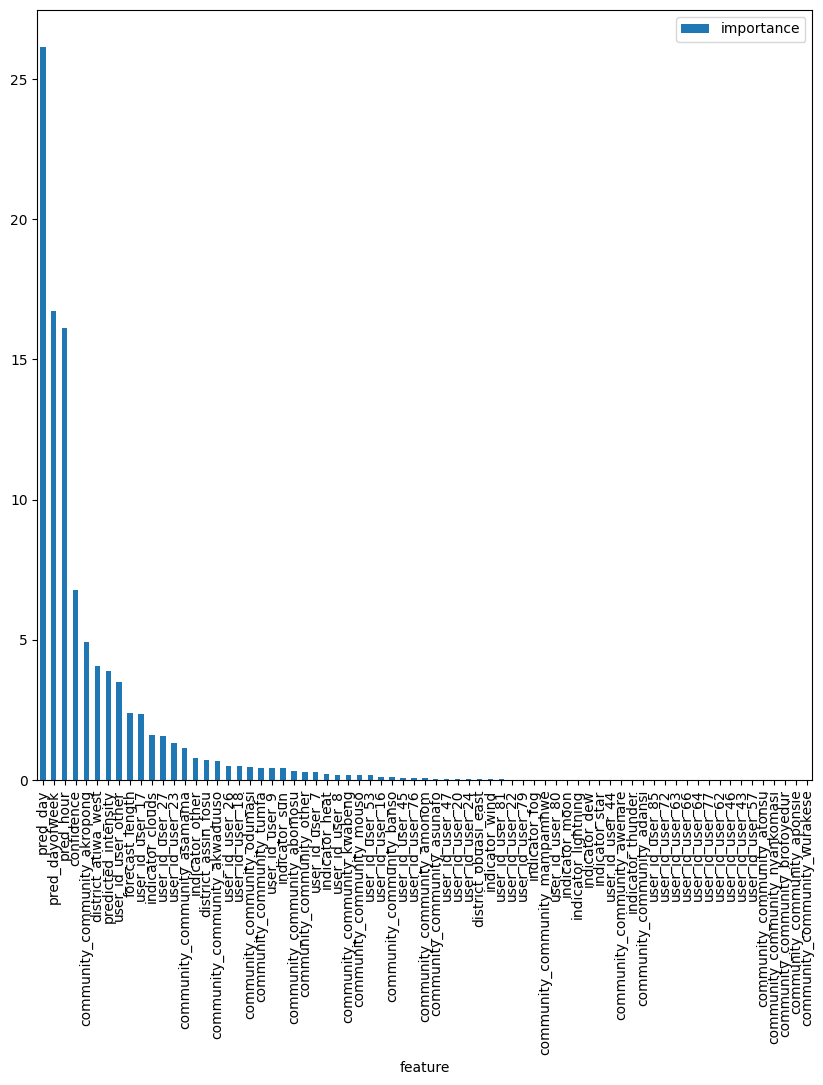

In [424]:
feature_inportance = pd.DataFrame({"feature": X.columns, "importance": cat_model.feature_importances_})
feature_inportance.sort_values(by="importance", ascending=False)


#plot

feature_inportance.sort_values(by="importance", ascending=False).plot(kind="bar", x="feature", y="importance", figsize=(10, 10))
plt.show()
